Запуск бэктестирования momentum стратегии...
Символ: BTCUSDT
Период: 2025-01-01 - 2025-06-08
Таймфрейм: 15m
SMA период: 50
Take Profit: 0.005%
Stop Loss: 0.002%

Загрузка данных для BTCUSDT с 2025-01-01 по 2025-06-08...
Загружено 1500 свечей...
Загружено 3000 свечей...
Загружено 4500 свечей...
Загружено 6000 свечей...
Загружено 7500 свечей...
Загружено 9000 свечей...
Загружено 10500 свечей...
Загружено 12000 свечей...
Загружено 13500 свечей...
Загружено 15000 свечей...
Загружено 15169 свечей...
Данные загружены: 15169 свечей с 2025-01-01 03:00:00 по 2025-06-08 03:00:00
РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ
Период: 2025-01-01 03:00 - 2025-06-08 03:00
Начальный капитал: $10,000.00
Конечный капитал: $1,824.52
Общая доходность: -81.75%
Максимальная просадка: -81.75%
Коэффициент Шарпа: -94.016

СТАТИСТИКА СДЕЛОК:
Всего сделок: 872
Прибыльных сделок: 125 (14.3%)
Убыточных сделок: 747 (85.7%)
Средняя прибыльная сделка: 0.28%
Средняя убыточная сделка: -0.27%
Профит-фактор: 0.17

ПОСЛЕДНИЕ 10 СДЕЛОК:
----

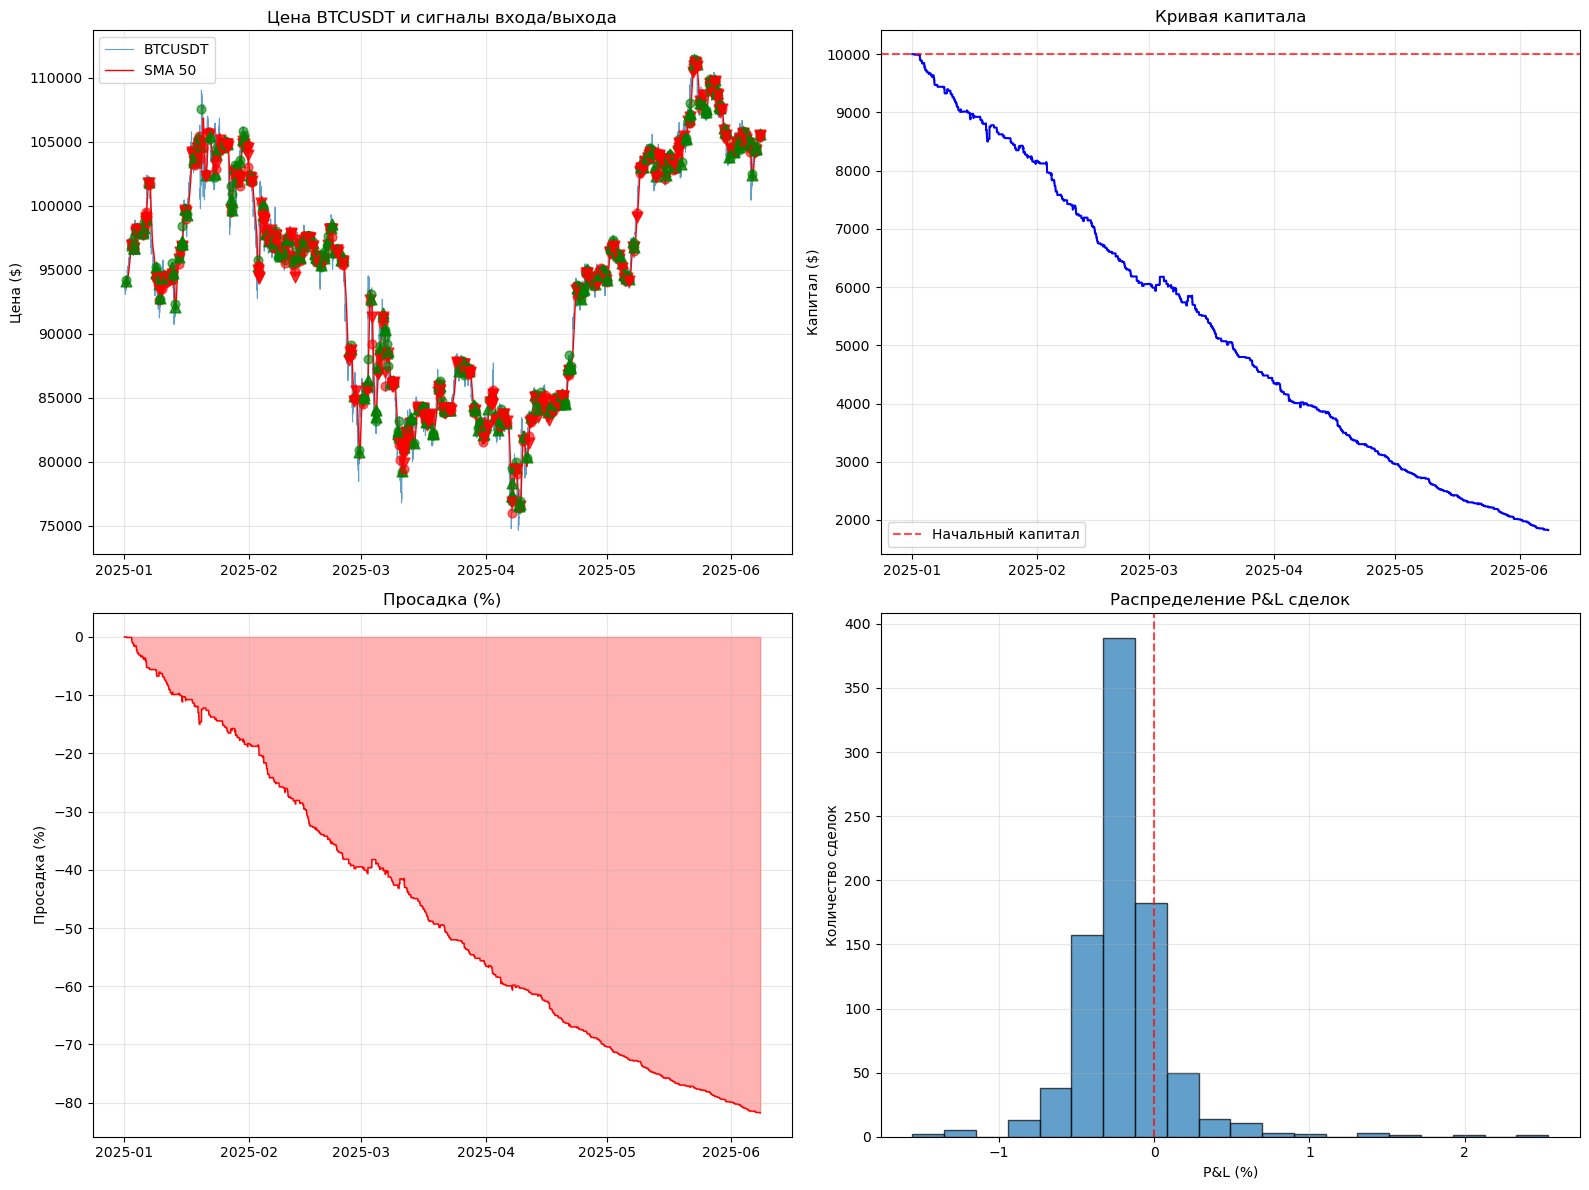

In [3]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timezone
import time
import warnings
warnings.filterwarnings('ignore')

# ============ НАСТРОЙКИ СТРАТЕГИИ ============
SYMBOL = 'BTCUSDT'
INTERVAL = '15m'
START_DATE = '2025-01-01'
END_DATE = '2025-06-08'
SMA_PERIOD = 50
TAKE_PROFIT_PCT = 0.005  # 0.5%
STOP_LOSS_PCT = 0.002    # 0.2%
INITIAL_CAPITAL = 10000  # $10,000
COMMISSION_PCT = 0.1    # 0.1% комиссия за сделку

# ============ ФУНКЦИИ ДЛЯ ЗАГРУЗКИ ДАННЫХ ============
def get_binance_data(symbol, interval, start_date, end_date):
    """Загрузка данных с Binance API"""
    base_url = 'https://fapi.binance.com/fapi/v1/klines'
    
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() * 1000)
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp() * 1000)
    
    all_data = []
    current_start = start_timestamp
    limit = 1500  # Максимальное количество свечей за запрос
    
    print(f"Загрузка данных для {symbol} с {start_date} по {end_date}...")
    
    while current_start < end_timestamp:
        params = {
            'symbol': symbol,
            'interval': interval,
            'startTime': current_start,
            'endTime': end_timestamp,
            'limit': limit
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if not data:
                break
                
            all_data.extend(data)
            current_start = data[-1][6] + 1  # Следующий запрос начинается с времени закрытия последней свечи + 1мс
            
            print(f"Загружено {len(all_data)} свечей...")
            time.sleep(0.1)  # Небольшая задержка для избежания rate limit
            
        except Exception as e:
            print(f"Ошибка при загрузке данных: {e}")
            break
    
    # Преобразование в DataFrame
    df = pd.DataFrame(all_data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_volume', 'trades', 'taker_buy_base',
        'taker_buy_quote', 'ignore'
    ])
    
    # Конвертация типов данных
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    for col in ['open', 'high', 'low', 'close', 'volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    
    print(f"Данные загружены: {len(df)} свечей с {df.index[0]} по {df.index[-1]}")
    return df

# ============ РАСЧЕТ ИНДИКАТОРОВ ============
def add_indicators(df):
    """Добавление технических индикаторов"""
    df['sma'] = df['close'].rolling(window=SMA_PERIOD).mean()
    
    # Сигналы пересечения
    df['price_above_sma'] = df['close'] > df['sma']
    df['price_above_sma_prev'] = df['price_above_sma'].shift(1)
    
    # Сигналы входа
    df['long_signal'] = (df['price_above_sma'] == True) & (df['price_above_sma_prev'] == False)
    df['short_signal'] = (df['price_above_sma'] == False) & (df['price_above_sma_prev'] == True)
    
    return df

# ============ БЭКТЕСТИРОВАНИЕ ============
def backtest_strategy(df):
    """Бэктестирование стратегии"""
    # Инициализация переменных
    capital = INITIAL_CAPITAL
    position = 0  # 0 - без позиции, 1 - лонг, -1 - шорт
    entry_price = 0
    entry_time = None
    
    # Списки для хранения результатов
    trades = []
    equity_curve = []
    
    for i, (timestamp, row) in enumerate(df.iterrows()):
        if pd.isna(row['sma']):
            equity_curve.append(capital)
            continue
            
        current_price = row['close']
        pnl_pct = 0
        
        # Если в позиции, проверяем условия выхода
        if position != 0:
            if position == 1:  # Лонг позиция
                pnl_pct = (current_price - entry_price) / entry_price * 100
                
                # Условия выхода из лонга
                exit_condition = (
                    pnl_pct >= TAKE_PROFIT_PCT or  # Тейк-профит
                    pnl_pct <= -STOP_LOSS_PCT or   # Стоп-лосс
                    (row['price_above_sma'] == False and row['price_above_sma_prev'] == True)  # Пересечение вниз
                )
                
            else:  # Шорт позиция
                pnl_pct = (entry_price - current_price) / entry_price * 100
                
                # Условия выхода из шорта
                exit_condition = (
                    pnl_pct >= TAKE_PROFIT_PCT or  # Тейк-профит
                    pnl_pct <= -STOP_LOSS_PCT or   # Стоп-лосс
                    (row['price_above_sma'] == True and row['price_above_sma_prev'] == False)  # Пересечение вверх
                )
            
            # Выход из позиции
            if exit_condition:
                # Определение причины выхода
                if pnl_pct >= TAKE_PROFIT_PCT:
                    exit_reason = 'Take Profit'
                elif pnl_pct <= -STOP_LOSS_PCT:
                    exit_reason = 'Stop Loss'
                else:
                    exit_reason = 'SMA Cross'
                
                # Расчет P&L с учетом комиссии
                pnl_net = pnl_pct - (2 * COMMISSION_PCT)  # Комиссия за вход и выход
                capital *= (1 + pnl_net / 100)
                
                # Запись сделки
                trades.append({
                    'entry_time': entry_time,
                    'exit_time': timestamp,
                    'side': 'Long' if position == 1 else 'Short',
                    'entry_price': entry_price,
                    'exit_price': current_price,
                    'pnl_pct': pnl_net,
                    'pnl_usd': INITIAL_CAPITAL * pnl_net / 100,
                    'exit_reason': exit_reason,
                    'capital': capital
                })
                
                position = 0
                entry_price = 0
                entry_time = None
        
        # Если без позиции, проверяем сигналы входа
        elif position == 0:
            if row['long_signal']:
                position = 1
                entry_price = current_price
                entry_time = timestamp
            elif row['short_signal']:
                position = -1
                entry_price = current_price
                entry_time = timestamp
        
        equity_curve.append(capital)
    
    df['equity'] = equity_curve
    trades_df = pd.DataFrame(trades)
    
    return trades_df, df

# ============ АНАЛИЗ РЕЗУЛЬТАТОВ ============
def analyze_results(trades_df, df):
    """Анализ результатов бэктестирования"""
    if len(trades_df) == 0:
        print("Сделок не совершено!")
        return
    
    # Основные метрики
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl_pct'] > 0])
    losing_trades = len(trades_df[trades_df['pnl_pct'] < 0])
    win_rate = winning_trades / total_trades * 100
    
    total_return = (df['equity'].iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
    
    # Максимальная просадка
    peak = df['equity'].expanding().max()
    drawdown = (df['equity'] - peak) / peak * 100
    max_drawdown = drawdown.min()
    
    # Средние показатели
    avg_win = trades_df[trades_df['pnl_pct'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl_pct'] < 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    
    # Профит-фактор
    gross_profit = trades_df[trades_df['pnl_pct'] > 0]['pnl_pct'].sum() if winning_trades > 0 else 0
    gross_loss = abs(trades_df[trades_df['pnl_pct'] < 0]['pnl_pct'].sum()) if losing_trades > 0 else 0
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
    
    # Коэффициент Шарпа (упрощенный)
    returns = df['equity'].pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(525600) if returns.std() != 0 else 0  # 525600 минут в году
    
    print("=" * 60)
    print("РЕЗУЛЬТАТЫ БЭКТЕСТИРОВАНИЯ")
    print("=" * 60)
    print(f"Период: {df.index[0].strftime('%Y-%m-%d %H:%M')} - {df.index[-1].strftime('%Y-%m-%d %H:%M')}")
    print(f"Начальный капитал: ${INITIAL_CAPITAL:,.2f}")
    print(f"Конечный капитал: ${df['equity'].iloc[-1]:,.2f}")
    print(f"Общая доходность: {total_return:.2f}%")
    print(f"Максимальная просадка: {max_drawdown:.2f}%")
    print(f"Коэффициент Шарпа: {sharpe_ratio:.3f}")
    print()
    print("СТАТИСТИКА СДЕЛОК:")
    print(f"Всего сделок: {total_trades}")
    print(f"Прибыльных сделок: {winning_trades} ({win_rate:.1f}%)")
    print(f"Убыточных сделок: {losing_trades} ({100-win_rate:.1f}%)")
    print(f"Средняя прибыльная сделка: {avg_win:.2f}%")
    print(f"Средняя убыточная сделка: {avg_loss:.2f}%")
    print(f"Профит-фактор: {profit_factor:.2f}")
    print()
    
    # Последние 10 сделок
    print("ПОСЛЕДНИЕ 10 СДЕЛОК:")
    print("-" * 100)
    recent_trades = trades_df.tail(10)
    for _, trade in recent_trades.iterrows():
        print(f"{trade['entry_time'].strftime('%m-%d %H:%M')} | {trade['side']:5} | "
              f"Entry: ${trade['entry_price']:8.2f} | Exit: ${trade['exit_price']:8.2f} | "
              f"P&L: {trade['pnl_pct']:6.2f}% | {trade['exit_reason']}")

# ============ ВИЗУАЛИЗАЦИЯ ============
def plot_results(df, trades_df):
    """Построение графиков результатов"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # График 1: Цена и SMA с сигналами
    ax1.plot(df.index, df['close'], label='BTCUSDT', linewidth=0.8, alpha=0.7)
    ax1.plot(df.index, df['sma'], label=f'SMA {SMA_PERIOD}', color='red', linewidth=1)
    
    # Отметки входов и выходов
    if len(trades_df) > 0:
        for _, trade in trades_df.iterrows():
            color = 'green' if trade['side'] == 'Long' else 'red'
            marker = '^' if trade['side'] == 'Long' else 'v'
            
            # Вход
            ax1.scatter(trade['entry_time'], trade['entry_price'], 
                       color=color, marker=marker, s=60, alpha=0.8, zorder=5)
            
            # Выход
            exit_marker = 'o'
            ax1.scatter(trade['exit_time'], trade['exit_price'], 
                       color=color, marker=exit_marker, s=40, alpha=0.6, zorder=5)
    
    ax1.set_title('Цена BTCUSDT и сигналы входа/выхода')
    ax1.set_ylabel('Цена ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # График 2: Кривая капитала
    ax2.plot(df.index, df['equity'], color='blue', linewidth=1.5)
    ax2.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', alpha=0.7, label='Начальный капитал')
    ax2.set_title('Кривая капитала')
    ax2.set_ylabel('Капитал ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # График 3: Просадка
    peak = df['equity'].expanding().max()
    drawdown = (df['equity'] - peak) / peak * 100
    ax3.fill_between(df.index, drawdown, 0, color='red', alpha=0.3)
    ax3.plot(df.index, drawdown, color='red', linewidth=1)
    ax3.set_title('Просадка (%)')
    ax3.set_ylabel('Просадка (%)')
    ax3.grid(True, alpha=0.3)
    
    # График 4: Распределение P&L сделок
    if len(trades_df) > 0:
        ax4.hist(trades_df['pnl_pct'], bins=20, alpha=0.7, edgecolor='black')
        ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7)
        ax4.set_title('Распределение P&L сделок')
        ax4.set_xlabel('P&L (%)')
        ax4.set_ylabel('Количество сделок')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============ ОСНОВНАЯ ФУНКЦИЯ ============
def main():
    """Основная функция"""
    print("Запуск бэктестирования momentum стратегии...")
    print(f"Символ: {SYMBOL}")
    print(f"Период: {START_DATE} - {END_DATE}")
    print(f"Таймфрейм: {INTERVAL}")
    print(f"SMA период: {SMA_PERIOD}")
    print(f"Take Profit: {TAKE_PROFIT_PCT}%")
    print(f"Stop Loss: {STOP_LOSS_PCT}%")
    print()
    
    # Загрузка данных
    try:
        df = get_binance_data(SYMBOL, INTERVAL, START_DATE, END_DATE)
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        return
    
    # Добавление индикаторов
    df = add_indicators(df)
    
    # Бэктестирование
    trades_df, df = backtest_strategy(df)
    
    # Анализ результатов
    analyze_results(trades_df, df)
    
    # Построение графиков
    plot_results(df, trades_df)
    
    return df, trades_df

# Запуск программы
if __name__ == "__main__":
    df, trades_df = main()